In [12]:
# Installation of FEniCS in Colab via
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

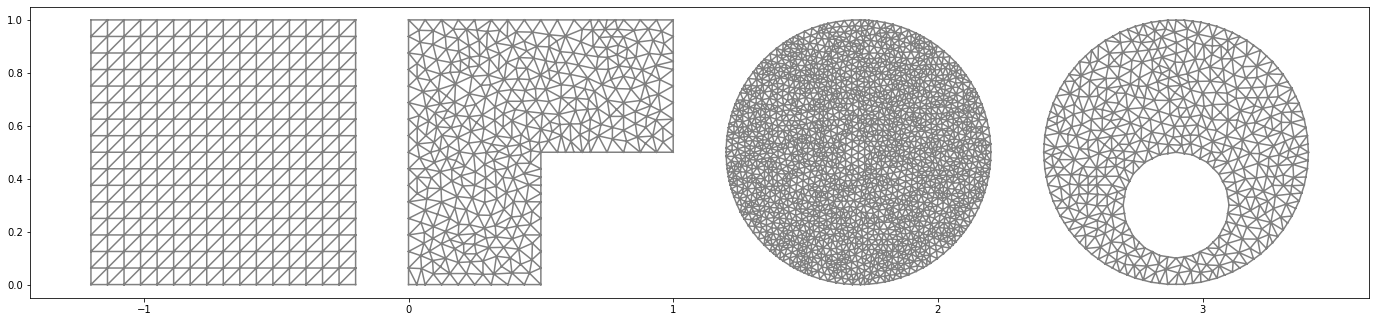

In [13]:
from fenics import *
from mshr import *
from pylab import plt
import numpy as np

# generate domains and meshes
Lshape  = Polygon([Point(0,0),Point(0.5,0),Point(0.5,0.5),Point(1,0.5),Point(1,1),Point(0,1)])
mesh1   = UnitSquareMesh(16,16)
mesh2   = generate_mesh(Lshape, 16)
mesh3   = generate_mesh(Circle(Point(0, 0),0.5), 32)
mesh4   = generate_mesh(Circle(Point(0, 0),0.5)-Circle(Point(0,-0.2),0.2),16)
mesh5   = generate_mesh(Rectangle(Point(-1.5, 0),Point(+1.5, 1)),196)
mesh6   = UnitCubeMesh(16,16,16)

# store meshes
fname1 = "meshes/square.xml"
fname2 = "meshes/Lshape.xml"
fname3 = "meshes/disc.xml"
fname4 = "meshes/donut.xml"
fname5 = "meshes/rectangle.xml"
fname6 = "meshes/cube.xml"
fname7 = "meshes/mesh_coarse.xml"
fname8 = "meshes/mesh_refined.xml"

File(fname1) << mesh1
File(fname2) << mesh2
File(fname3) << mesh3
File(fname4) << mesh4
File(fname5) << mesh5
File(fname6) << mesh6

# plot meshes
fig = plt.figure(figsize=(24,8))
mesh1.translate(Point(-1.2,0))
mesh3.translate(Point(+1.7,0.5))
mesh4.translate(Point(2.9,0.5))
plot(mesh1)
plot(mesh2)
plot(mesh3)
plot(mesh4)

### Example 1: Poisson problem ### 

**Task:** Solve the 2D Poisson problem 

$-\nabla^2 u =f$ in $\Omega$ with
$u=0$ ($\Gamma_D$) or $\nu\cdot\nabla u=g$ ($\Gamma_N$) on the boundary $\partial\Omega=\Gamma_D\cup\Gamma_N$.

using the Finite Element Method (FEM) in the standard weak form

$$
\int_\Omega \nabla u\cdot\nabla v\,\mathrm{d}x = \int_\Omega fv\,\mathrm{d}x + \int_{\Gamma_N} gv\,\mathrm{d}s
$$

with *essential boundary conditions* $u=0$ on $\partial\Omega$ and $f(x)\equiv1$.

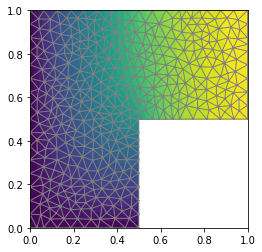

In [6]:
mesh  = Mesh(fname2)
# mesh  = UnitSquareMesh(200,200)
# mesh   = UnitCubeMesh(16,16,16)

V     = FunctionSpace(mesh, "CG", 2)

def boundary(x):
    tol = 1e-10 #what is tol?
    return near(x[1], 0, tol) or near(x[0],0,tol)

# Define boundary condition
bc = DirichletBC(V, Constant(0.0),boundary)
# bc = DirichletBC(V, Constant(0.0),'on_boundary')

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)",degree=2)
f = Expression("1.0",degree=2)

g = Expression("-0.5*x[0]",degree=2)
a = inner(grad(u), grad(v))*dx
L = f*v*dx #+ g*v*ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
plot(u)
plot(mesh,linewidth=1)

### Example 2: Poisson problem ### 

**Task:** Solve the 2D Poisson problem 

$-\nabla^2 u =f$ in $\Omega$ with
$u=0$ on $\partial\Omega$

using the Finite Element Method (FEM) as a minimization problem, i.e., we minimize the energy

$E(u)=\int_\Omega \frac12|\nabla u|^2-fu\,{\rm d}x$

with *essential boundary conditions* $u=0$ on $\partial\Omega$ and $f(x)\equiv1$.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


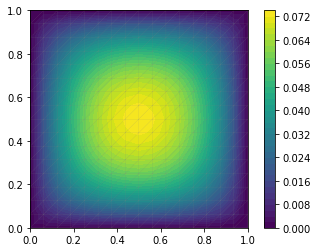

In [14]:
mesh  = Mesh(fname1)                               #define mesh  
Q     = FunctionSpace(mesh, 'CG', 1)               #define Lagrange elements
bc    = DirichletBC(Q, Constant(0), 'on_boundary') #define boundary conditions

q     = Function(Q)     # define unknown function
v     = TestFunction(Q) # define test function
f     = Constant(1.0)   # define right-hand-side
#f    = Expression(('x[0]*x[1]+x[1]+sin(x[0])'),degree=2)

E     = 0.5*inner(grad(q),grad(q))*dx - f*q*dx
Res   = derivative(E, q, v)
         
solve(Res == 0, q, bc) 
c=plot(q)
plot(mesh,linewidth=0.1)
plt.colorbar(c); # plot solution, mesh and colors

### Example 3: Plateau's problem ### 
This goes back to a problem formulated mathematically by Joseph-Louis Lagrange in the year 1760 and is named after the Belgian physicist Joseph Plateau, who demonstrated in 1849 that minimal surfaces can be created by immersing wire frames into soapy water.

Consider the surface energy

$E(q)=\int_\Omega \sqrt{1+ |\nabla q|^2}\,{\rm d}x$

describing the surface energy $E=|\Gamma|$ of

$\Gamma=\{(x,z)\in\mathbb{R}^{d+1}:z=q(x)\}$

when fixed in a wireframe $q=g$ on $\partial\Omega$. Here we use $g=\tfrac12\tanh(50(y-1/2))$.

<img src="https://www.wias-berlin.de/people/peschka/plateau_img.png" width="30%">


Internally, FEniCS needs to take care of the first derivative (which we call the residual/nonlinear form `Res`)

$\texttt{Res}(q)_i=\langle {\rm D}E(q),\varphi_i\rangle =\int \frac{\nabla q\cdot\nabla \varphi_i}{(1+|\nabla q|^2)^{1/2}}\,{\rm d}x\overset{!}{=}0 \quad\forall i\quad\Leftrightarrow\quad \frac{\delta E}{\delta q}=-\nabla\cdot \frac{\nabla q}{(1+|\nabla q|^2)^{1/2}}\overset{!}{=}0$

which is solved by Newton's method using the second derivative $\texttt{F}(q)$ via

$
q^{k+1}=q^k - \texttt{F}^{-1}(q^k)\texttt{Res}(q^k), \qquad \texttt{F}_{ij}(q)=\partial_{q_j} \texttt{Res}(q)_i,
$

for a sufficiently good initial guess $q^0$ and finite element basis functions $\varphi_i$. The *magic* happens in the function `derivative(E, q, v)`, which computes `Res` and then internally the second derivative (Jacobian). The FEniCS function `solve` then invokes a solver (Newton iteration) for the nonlinear variational problem.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


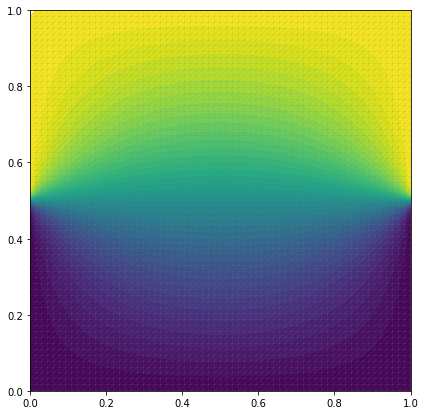

In [15]:
from fenics import *
from pylab  import plt

mesh = UnitSquareMesh(64,64)

g    = Expression('0.5*tanh(50*(x[1]-0.5))', degree=2)

Q   = FunctionSpace(mesh,'CG', 1)   # define elements
bc  = DirichletBC(Q,g,'on_boundary') # define boundary conditions
q   = Function(Q)     # define unknown function
v   = TestFunction(Q) # define test function

E     = sqrt(1+inner(grad(q),grad(q)))*dx
Res   = derivative(E, q, v)      
solve(Res == 0, q, bc) 

fig = plt.figure(figsize=(12,7))
plot(q)
plot(mesh,linewidth=0.1)

### Example 4: Convection-diffusion problem ###

We solve the time-dependent problem




\begin{align}
\int_\Omega \partial_t q v\mathrm{d}x + a(q,v)=0
\end{align}

where

$$
a(q,v)=\int_\Omega \alpha\nabla q\cdot\nabla v + (\vec{u}\cdot\nabla q)v\mathrm{d}x
$$

for given functions $\alpha,\vec{u}$.

In [3]:
# FE definitions
mesh = Mesh(fname3)
Q    = FunctionSpace(mesh,"CG",1)

# single time step
def evolve(old_q, tau):
    q,v  = Function(Q),TestFunction(Q)
    dqdt = (q - old_q)/tau
    
    Res  = inner(dqdt,v)*dx + alpha*inner(grad(q),grad(v))*dx + inner(u,grad(q))*v*dx

    q.assign(old_q)
    solve(Res==0, q ) 
    return q
    
# main time loop /Mathematic part 
alpha   = Constant(1e-4)
n_steps = 150
tau     = np.pi/n_steps
t       = 0.0

u     = Expression(("-x[1]","x[0]"),degree=2)
old_q = interpolate(Expression(("tanh(x[0]*20)"),degree=2),Q)
file  = File("lecture08_example04.pvd")

for i in range(n_steps):
   t = t + tau
   q = evolve(old_q, tau)
   q.rename("q","q")
   file << (q,t)
   old_q.assign(q)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


### Example 5: Cahn-Hilliard equation ###

In the talk the Cahn-Hilliard equation was motivated with an energy

\begin{align}
&\mathcal{E}(\varphi)=\int_\Omega \tfrac\varepsilon2 |\nabla \varphi|^2 + \varepsilon^{-1}W(\varphi)\,{\rm d}x\\
&W(\varphi)=\tfrac12(1-\varphi^2)^2
\end{align}

and bilinear forms


\begin{align}
&a_\varphi(\eta,\xi)=\int_\Omega m(\varphi)\nabla\eta\cdot\nabla\xi\,{\rm d}x \\
&b(v,\xi)=\int_\Omega v\xi\,{\rm d}x
\end{align}

where below for simplicity we set $m\equiv 1$. This generates the saddle-point problem

\begin{align*}
a_\varphi(\eta,\xi)+b(\partial_t \varphi,\xi)&=0\\
b(v,\eta)&=\langle \mathrm{D}\mathcal{E}(\varphi),v\rangle
\end{align*}

shown in `line 16-18` in the cell below. The problem is solved with $P_1$ FE on the domain $\Omega=[-3/2,3/2]\times[0,1]$ with randomized initial data, where the average value changes over space.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


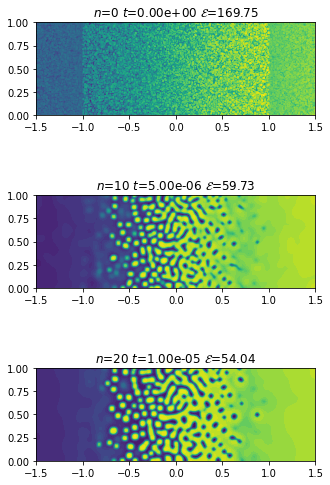

In [9]:
# FE definitions
mesh = Mesh(fname5)
FE   = FiniteElement("P", mesh.ufl_cell(), 1)   # scalar element
UxQ  = FunctionSpace(mesh,MixedElement([FE,FE]))# mixed space

# single time step
def evolve(old_q_ext, tau):
    q_ext,v_ext     = Function(UxQ),TestFunction(UxQ)
    eta,phi         = split(q_ext)
    xi,v            = split(v_ext)
    old_eta,old_phi = split(old_q_ext)

    E  = eps/2*inner(grad(phi),grad(phi))*dx + 1/(2*eps)*(1-phi**2)**2*dx
    Res  = tau*inner(grad(eta),grad(xi))*dx + xi*(phi-old_phi)*dx 
    Res += eta*v*dx - derivative(E, q_ext, v_ext)
    
    q_ext.assign(old_q_ext)
    solve(Res==0, q_ext ) 
    E = assemble(E)   
    return q_ext,E
    
# main time loop
n_steps = 20
eps     = 0.01
tau     = 0.5e-6
t       = 0.0

old_q_ext   = interpolate(Expression(("0.0","x[0]/pow(1+x[0]*x[0],0.5)+(1-abs(x[0])/pow(1+x[0]*x[0],0.5))*(2*(float)(rand())-1)"),degree=2),UxQ)
old_q_ext,E = evolve(old_q_ext,1e-9)

mprint = 0
fig = plt.figure(figsize=(5,3*3))
for i in range(n_steps+1):
   if (i % 10 == 0):
      plt.subplot(3,1,mprint+1)
      plot(old_q_ext.sub(1),title="$n$="+str(i)+" $t$="+f'{t:.2e}'+" $\mathcal{E}$="+f'{E:.2f}')
      mprint += 1

   t = t + tau
   q_ext,E = evolve(old_q_ext, tau)
   old_q_ext.assign(q_ext)

### Example 6: Finite elements with deformation. ###

Consider the previous Poisson problem 

$\int_{\Omega} \nabla \varphi\cdot\nabla v\,{\rm d}x=\int_\Omega fv\,{\rm d}x$

and a smooth invertible deformation $\chi=\mathrm{id}+u$ (diffeomorphism) with displacement $u:\bar\Omega\to \Omega$. Then the transformed finite element formulation is

$\int_{\bar\Omega} F^{-\top}\nabla \varphi\cdot F^{-\top}\nabla v\, J{\rm d}X=\int_{\bar\Omega} fv J\,{\rm d}X$ 

with $F=\mathbb{I}+\nabla u$ and $J=\det F$. 

While in this example the mapping is constant (in time) and predefined, the simple change of coordinates formula provides us with an effective tool to consider free boundary problems, where the motion of a domain is incorporated into a moving domain $\Omega(t)=\chi(t,\bar{\Omega})$.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


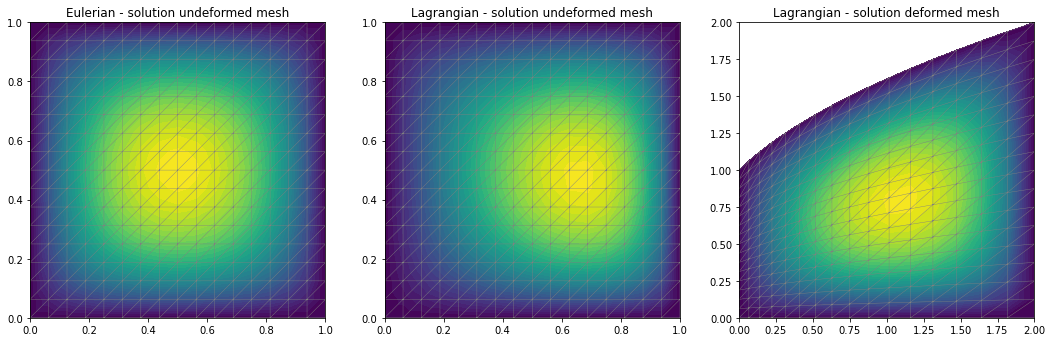

In [4]:
from fenics import *
from pylab import plt
import numpy as np

mesh = Mesh(fname1)                                   # define mesh                          
Q    = FunctionSpace(mesh, "CG", 1)                   # define elements
bc   = DirichletBC(Q, Constant(0.0), 'on_boundary')   # define boundary conditions


map  = Expression(('x[0]*x[0]','x[1]*x[0]'),pi = np.pi, degree=2)

#map  = Expression(('0.3*sin(pi*x[0])*cos(1.25*pi*x[1])','0.2*cos(pi*x[0])*sin(pi*x[1])'),pi = np.pi, degree=2)
u    = interpolate(map,VectorFunctionSpace(mesh, "CG", 1))

phi  = Function(Q)     # define unknown function
v    = TestFunction(Q) # define test function
f    = Constant(1.0)   # define right-hand-side

E     = 0.5*inner(grad(phi),grad(phi))*dx - inner(f,phi)*dx
Res   = derivative(E, phi, v)         
solve(Res == 0, phi, bc) 

fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plot(phi)
plot(mesh,linewidth=0.4,title='Eulerian - solution undeformed mesh');

F     = Identity(2) + grad(u)
J     = det(F)
E     = 0.5*inner(inv(F).T*grad(phi),inv(F).T*grad(phi))*J*dx - inner(f,phi)*J*dx
Res   = derivative(E, phi, v)         
solve(Res == 0, phi, bc)   

# Plot Lagrangian solution before ALE displacement
plt.subplot(1,3,2)
plot(phi)
plot(mesh,linewidth=0.4,title='Lagrangian - solution undeformed mesh');

# Plot Lagrangian solution after ALE displacement
plt.subplot(1,3,3)
ALE.move(mesh,u)     # Move coordinates of mesh according to displacement function u
plot(phi)
plot(mesh,linewidth=0.4,title='Lagrangian - solution deformed mesh');

### Example 7: Different boundary conditions ###

Below the most common boundary conditions are demonstrated, i.e.

* inhomogeneous Dirichlet boundary conditions
* inhomogeneous Neumann boundary conditions
* periodic boundary conditions

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


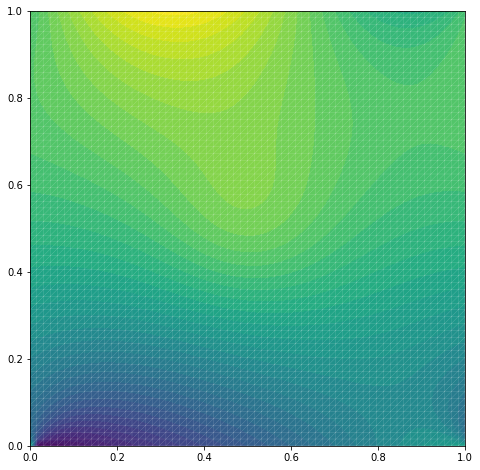

In [5]:
# Solve -div(grad(u))=f with boundary conditions
from fenics import *
from pylab import plt
import numpy as np

# Define boundary
tol     = 1E-12
def boundary_bottom(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def boundary_top(x, on_boundary):
    return on_boundary and near(x[1], 1, tol)

def boundary_left(x, on_boundary):
    return on_boundary and near(x[0], 1, tol)

class PeriodicBC(SubDomain): # marker periodic left & right
    def inside(self, x, on_boundary):
        return near(x[0],0.0,tol) and on_boundary
    def map(self, x, y):
        y[0] = x[0] - 1.0
        y[1] = x[1] 

# FE definitions        
mesh    = UnitSquareMesh(64,64)        
V       = FunctionSpace(mesh, "CG", 1, constrained_domain=PeriodicBC())                  

u_D     = Expression("0.5*x[0]",degree=2)
f       = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)",degree=2)
g       = Expression("sin(5*x[0])",degree=2)

#dbc_l   = DirichletBC(V, Constant(0.0), boundary_left)      # hom DBC
dbc_b   = DirichletBC(V, u_D, boundary_bottom)              # inhom DBC
bc      = [dbc_b]       #bc    = [dbc_b,dbc_l]

facets  = MeshFunction("size_t", mesh, 1)
AutoSubDomain(boundary_top).mark(facets, 1)
ds      = Measure("ds", subdomain_data=facets)

# Define variational problem
u,v = TrialFunction(V),TestFunction(V)
a   = inner(grad(u), grad(v))*dx 
L   = f*v*dx + g*v*ds(1)

# Compute solution
u  = Function(V)
solve(a == L, u, bc)

# Plot solution
fig = plt.figure(figsize=(18,8))
plot(u)
plot(mesh,linewidth=0.1,color='white',title='')

### Example 8: Incompressibility ###

Below you see the two ways to enforce an incompressibility constraint using finite elements

1. via Chorin's projection
2. via Langrange multiplier

First, we say we want to solve

$$
-\Delta\vec{u}=\vec{f}
$$

subject to an incompressibility constraint $\nabla\cdot \vec{u}=0$. This certainly imposes $\nabla\cdot\vec{f}=0$ on the right hand side. 

1. We can solve it (tentatively) by first solving without the constraint and then projecting via the Chorin projection.

2. We can solve the coupled problem

\begin{align}
-\Delta\vec{u} + \nabla p = \vec{f}\\
\nabla\cdot\vec{u}=0
\end{align}

Both approaches are implemented below and will be discussed in the lecture.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Divu= 0.028781113442800432
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Divu= 0.00013922028648140266
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


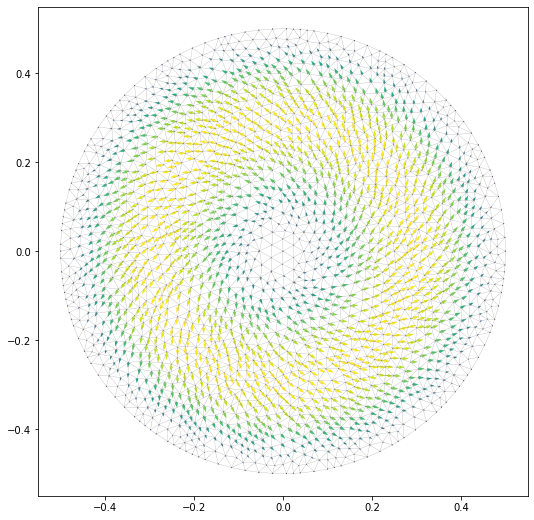

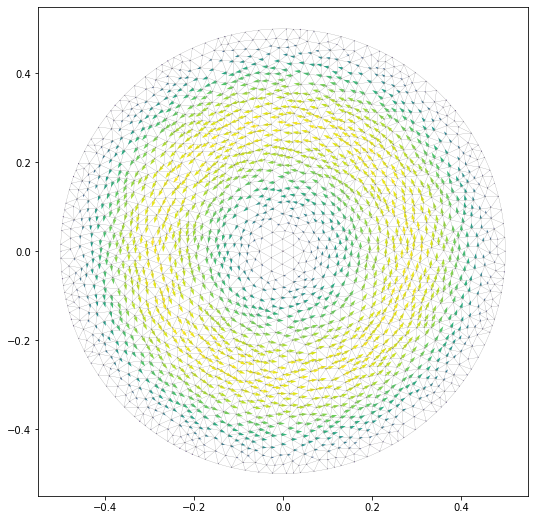

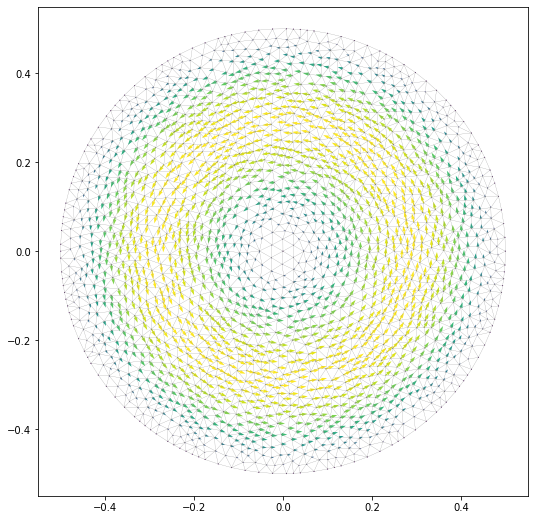

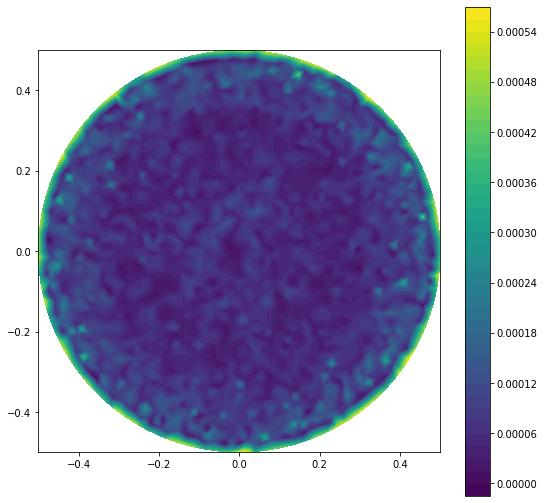

In [12]:
from fenics import *
from pylab import plt
import numpy as np

mesh = Mesh(fname3)                                   # define mesh                          

# Part 1a: Vectorial problem for u
V    = VectorFunctionSpace(mesh,"CG",2)

bc   = DirichletBC(V, Constant((0.0,0.0)), 'on_boundary')   # define boundary conditions

u    = Function(V)     # define unknown function
v    = TestFunction(V) # define test function
f    = Expression(("x[0]-x[1]","x[1]+x[0]"),degree=2)

E     = 0.5*inner(grad(u),grad(u))*dx - inner(f,u)*dx
Res   = derivative(E, u, v)         
solve(Res == 0,u,bc) 

plt.figure(figsize=(9,9))
plot(u)
plot(mesh,linewidth=0.2)

# Part 1b: Chorin projection for u
Q    = FunctionSpace(mesh, "CG", 1)
phi  = Function(Q)
v    = TestFunction(Q)

eps  = 1e-4
E    = 0.5*inner(grad(phi),grad(phi))*dx + eps*phi*phi*dx + inner(div(u),phi)*dx
Res  = derivative(E, phi, v)     

solve(Res == 0,phi) 

w = project(u-grad(phi),V)

plt.figure(figsize=(9,9))
plot(w)
plot(mesh,linewidth=0.2)

print("Divu=",np.sqrt(assemble(div(w)*div(w)*dx)))


# Part 2: Saddle point problem for Stokes (u,p)
P1   = FiniteElement("P", mesh.ufl_cell(), 1)    # scalar element
P2   = VectorElement("P", mesh.ufl_cell(), 2)    # vector element
Q    = FunctionSpace(mesh,MixedElement([P2,P1])) # mixed space

bc1   = DirichletBC(Q.sub(0), Constant((0.0,0.0)), 'on_boundary')   # define boundary conditions


q    = Function(Q)     # define unknown function
dq   = TestFunction(Q) # define test function
u,p  = split(q)

L     = 0.5*inner(grad(u),grad(u))*dx + p*div(u)*dx - inner(f,u)*dx
Res   = derivative(L, q, dq)         
solve(Res == 0,q,bc1) 

plt.figure(figsize=(9,9))
u = q.sub(0)
plot(u)
plot(mesh,linewidth=0.2)
print("Divu=",np.sqrt(assemble(div(u)*div(u)*dx)))

plt.figure(figsize=(9,9))
e = project(u-w,V)
c = plot(sqrt(inner(e,e)))
plt.colorbar(c)

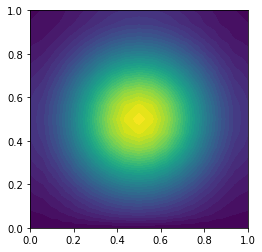

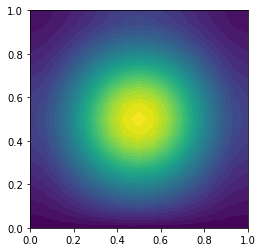

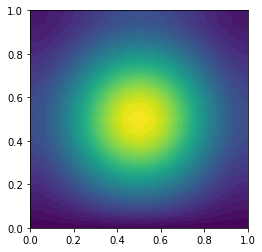

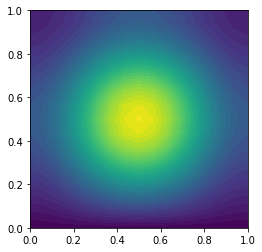

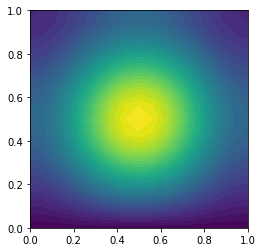

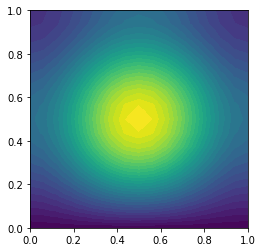

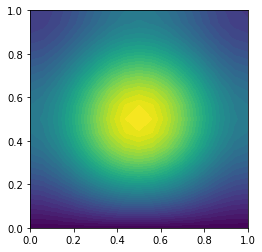

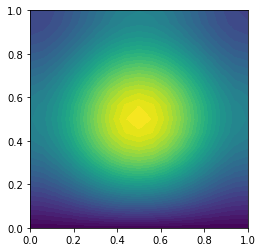

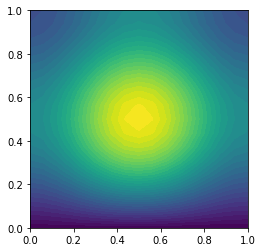

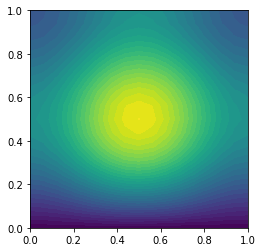

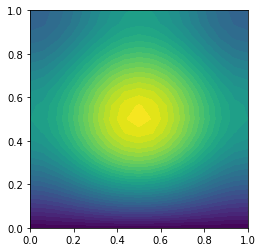

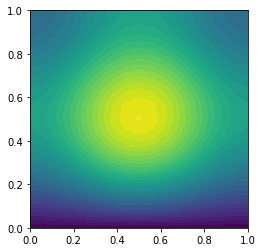

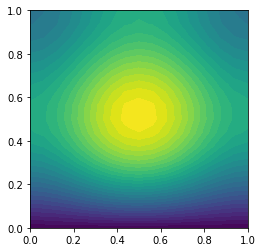

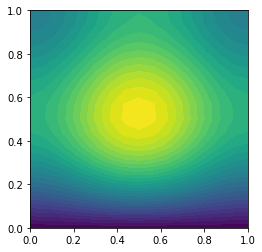

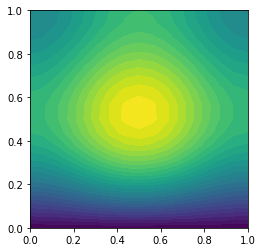

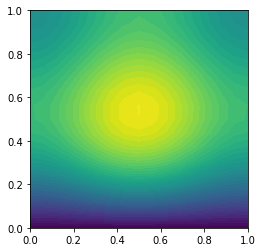

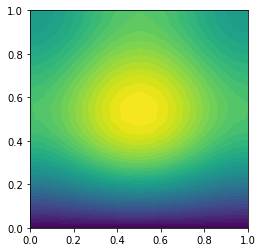

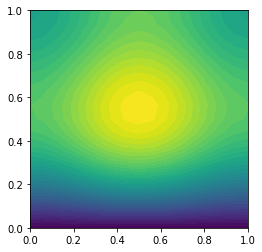

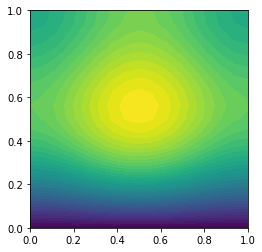

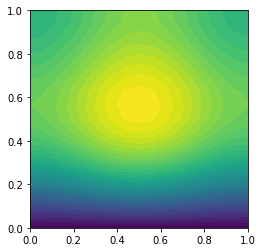

In [11]:
# Discussion Dirk Peschka and Negin Tavakkoli
# This codes solves a heat equation, where theta refers to the 
# temperature (in order to not be confused with current time T
# or final time T)
#
# In order to solve the Boussinesq approximation (see https://en.wikipedia.org/wiki/Boussinesq_approximation_(buoyancy))
# this code needs to be combined with the Navier-Stokes solver (with Taylor Hood finite elements) that
# you find in Lecture09_solution. They key ingredient is to understand how to combine both weak formulations
# by making the space larger in the sense
#
# P1        = FiniteElement("P", mesh.ufl_cell(), 1)
# P2        = VectorElement("P", mesh.ufl_cell(), 2)
# V         = FunctionSpace(mesh,MixedElement([P2,P1,P1]))
# q         = Function(V)
# u,p,theta = split(q)
#
# where "u" is the velocity field, "p" is the pressure field, and "theta" is the temperature field
# and in "Res = ..." you need to find a suitable weak form for this coupled problem.
#
# Once this works, you can make the output nice, go to a more sophisticated problem setup (geometry)
# and also implement Navier-Stokes-Cahn-Hilliard equations.

from fenics import *
from mshr import *
from pylab import plt
import numpy as np

# generate domains and meshes
mesh   = UnitSquareMesh(16,16)
Q      = FunctionSpace(mesh,"CG",1)

# Define boundary condition
# 1. Pick interfaces
def boundary_bottom(x):
    tol = 1e-15
    return near(x[1], 0, tol)

def boundary_top(x):
    tol = 1e-3
    return near(x[1],10.0, tol)

# 2. Pick values to assign to interfaces
bc1 = DirichletBC(Q, Constant(0.0),boundary_bottom)
bc2 = DirichletBC(Q, Constant(1.0),boundary_top)
bc  = [bc1,bc2]

# single time step in weak form
def evolve(old_theta, tau):
    theta,v  = Function(Q),TestFunction(Q)
    dthetadt = (theta - old_theta)/tau
    
    Res  = inner(dthetadt,v)*dx + alpha*inner(grad(theta),grad(v))*dx 
    q.assign(old_theta)
    solve(Res==0 , theta , bc) 
    return theta
    
# main time loop
T       = 1.0
alpha   = Constant(5e-2)
n_steps = 20
tau     = T/n_steps
t       = 0.0

# set initial data
old_theta = interpolate(Expression(("exp(-10*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2)))"),degree=2),Q)

# solve and plot
for i in range(n_steps):
    t = t + tau
    theta = evolve(old_theta, tau)
    old_theta.assign(theta)

    plt.figure()
    plot(old_theta)